# Model evaluation
This notebook aims at evaluating the models trained in the `model_training.ipynb` notebook.

In [1]:
import joblib
from tfidf_extractor import is_valid_csv, write_to_file, load_and_vectorize
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
MODELS_DIR = "./../models/"
MODELS_EXTENSION = ".pkl"
PROCESSED = "./../data/processed/"
RAW = "./../data/raw/"

In [3]:
raw_files = [
    f"{RAW}train.csv",
    f"{RAW}test.csv",
    f"{RAW}validation.csv"
]

processed_files = [
    f"{PROCESSED}train_features.csv",
    f"{PROCESSED}test_features.csv",
    f"{PROCESSED}validation_features.csv"
]

model_names = [
    "decision_tree",
    "gaussian_nb",
    "lr_l1",
    "lr_l2",
    "mlp"
]

In [4]:
def load_model(model : str):
    return joblib.load(MODELS_DIR + model + MODELS_EXTENSION)

### Loading the models


In [5]:
models = {}

for name in model_names:
    models[name] = load_model(name)

### Loading and preprocessing the test dataset

In [6]:
# Check if processed files are valid; if not, process raw data
need_preprocessing = not all(is_valid_csv(file) for file in processed_files)

if need_preprocessing:
    print("Processing raw data and extracting TF-IDF features...")
    
    # Check if raw files are valid
    if not all(is_valid_csv(file) for file in raw_files):
        print("ERROR: Raw data files appear to be Git LFS pointers.")
        print("Please run: git lfs pull")
        print("Or download the actual data files manually.")
        raise FileNotFoundError("Raw data files are not available. Please pull from Git LFS.")
    
    X_train, y_train, X_test, y_test, X_val, y_val, vectorizer = load_and_vectorize(
        train_path=raw_files[0],
        test_path=raw_files[1],
        validation_path=raw_files[2]
    )

    # Save processed data
    write_to_file(processed_files[0], X_train, y_train)
    write_to_file(processed_files[1], X_test, y_test)
    write_to_file(processed_files[2], X_val, y_val)
    
    print("TF-IDF feature extraction completed. Files saved.")
else:
    print("Processed files already exist and are valid. Skipping preprocessing.")

Processed files already exist and are valid. Skipping preprocessing.


In [7]:
# Load processed data
try:
    df_test = pd.read_csv(processed_files[1])
    
    # Verify the data was loaded correctly
    print(f"Test set shape: {df_test.shape}")
    print(f"\nTest set columns: {df_test.columns.tolist()[:5]}... (showing first 5)")
    print(f"Test set has 'Label' column: {'Label' in df_test.columns}")
    
    if 'Label' not in df_test.columns:
        raise ValueError("'Label' column not found in processed data. Please regenerate the processed files.")
        
except Exception as e:
    print(f"Error loading processed data: {e}")
    print("\nIf you see Git LFS pointer errors, you need to:")
    print("1. Install Git LFS: brew install git-lfs (on macOS) or visit https://git-lfs.github.com/")
    print("2. Initialize Git LFS: git lfs install")
    print("3. Pull the actual files: git lfs pull")
    print("\nAlternatively, run the preprocessing cell above to regenerate the processed files.")
    raise

Test set shape: (6324, 5001)

Test set columns: ['0', '1', '2', '3', '4']... (showing first 5)
Test set has 'Label' column: True


### Evaluating the models

In [8]:
X_test = df_test.drop(columns=["Label"])
y_test = df_test["Label"]

In [9]:
results = {}
roc_data = {}

for name, model in models.items():
    # predictions
    y_pred = model.predict(X_test)

    # classification metrics
    results[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average="weighted"),
        "recall": recall_score(y_test, y_pred, average="weighted"),
        "f1": f1_score(y_test, y_pred, average="weighted")
    }

    # ROC/AUC if available
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        roc_data[name] = {
            "fpr": fpr,
            "tpr": tpr,
            "auc": roc_auc
        }

metrics_df = pd.DataFrame(results).T

In [10]:
metrics_df

,accuracy,precision,recall,f1
decision_tree,0.796964,0.798082,0.796964,0.796755
gaussian_nb,0.854364,0.854477,0.854364,0.854356
lr_l1,0.900538,0.900540,0.900538,0.900537
lr_l2,0.904333,0.904333,0.904333,0.904332
mlp,0.916983,0.917049,0.916983,0.916981


## ROC Curve and AUC for best classifier
The Multi-Layer perceptron is without a doubt the best classifier, achieving the best scores in all four metrics. Let us draw its ROC Curve and AUC score.

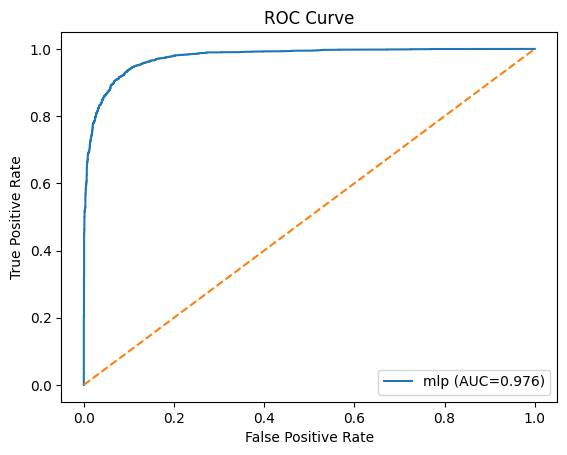

Best model: mlp
AUC: 0.9760


In [11]:
best_name = max(roc_data, key=lambda m: roc_data[m]["auc"])
data = roc_data[best_name]

plt.plot(data["fpr"], data["tpr"], label=f"{best_name} (AUC={data['auc']:.3f})")
plt.plot([0, 1], [0, 1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

print("Best model:", best_name)
print(f"AUC: {data["auc"]:.4f}")